In [98]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import optimize, stats
from scipy.special import comb

In [2]:
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous\\research'

In [3]:
os.chdir("../")
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous'

### Kendall tau estimation

In [4]:
def bw_scott(data: np.ndarray):
    std_dev = np.std(data, axis=0, ddof=1)
    n = len(data)
    return 3.49 * std_dev * n ** (-0.333)

def bw_silverman(data: np.ndarray):
    def _select_sigma(x):
        normalizer = 1.349
        iqr = (stats.scoreatpercentile(x, 75) - stats.scoreatpercentile(x, 25)) / normalizer
        std_dev = np.std(x, axis=0, ddof=1)
        return np.minimum(std_dev, iqr) if iqr > 0 else std_dev
    sigma = _select_sigma(data)
    n = len(data)
    return 0.9 * sigma * n ** (-0.2)

def bw_mlcv(data: np.ndarray, k):
    """
    Ref: https://rdrr.io/cran/kedd/src/R/MLCV.R
    """
    n = len(data)
    x = np.linspace(np.min(data), np.max(data), n)
    def mlcv(h):
        fj = np.zeros(n)
        for j in range(n):
            for i in range(n):
                if i == j: continue
                fj[j] += k((x[j] - data[i]) / h)
            fj[j] /= (n - 1) * h
        return -np.mean(np.log(fj[fj > 0]))
    h = optimize.minimize(mlcv, 1)
    if np.abs(h.x[0]) > 10:
        return bw_scott(data)
    return h.x[0]


In [5]:
def kernel(k: str):
    """Kernel function

    Args:
        k (str): kernel name: ['gaussian', 'epanechnikov']
    """
    if k not in ['gaussian', 'epanechnikov']:
        raise ValueError('Unknown kernel')
    
    def bounded(f): # decorator
        def _f(x):  # wrapper function
            return f(x) if np.abs(x) <= 1 else 0
        return _f
    
    if k == 'gaussian':
        return lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * u * u)
    elif k == 'epanechnikov':
        return bounded(lambda u: (3 / 4 * (1 - u * u)))
    
    
def kernel_weights(t, s, h, S, k=None):
    if k is None:
        k = kernel('epanechnikov')
    wh = k((t - s)/(S*h))
    return wh/(S*h)

# calculate tau 
def kendall_tau_estimator(Y_A, Y_B, h=None):
    assert len(Y_A) == len(Y_B), "Length Y_A and Y_B must be same"
    if h is None:
        h = 0.1
        print(h)
    S = len(Y_A) # both Y_A and Y_B needs to be of equal length
    tau_estimates = []
    # Create kernel function
    k = kernel('epanechnikov')
    for t in range(1,S+1):
        # weights = np.array([k((t - s) / (S * h)) / (S * h) for s in range(1, S + 1)])
        weights = np.array([kernel_weights(t, s, h, S) for s in range(1, S+1)])
        normalize = 1 - np.sum(weights**2)
        if normalize <=0:
            raise ValueError("Normalization is less than 0, Adjust 'h'")
        summed_weights = 0
        # for s_idx, s in enumerate(range(1, S + 1)):
        #     for r_idx, r in enumerate(range(1, S + 1)):
        #         # Indicator function: I[{Y_A(s) < Y_A(r), Y_B(s) < Y_B(r)}]
        #         # Using 0-indexing for arrays
        #         indicator = int((Y_A[s_idx] < Y_A[r_idx]) and (Y_B[s_idx] < Y_B[r_idx]))
                
        #         summed_weights += weights[s_idx] * weights[r_idx] * indicator
        # Vectorized computation using broadcasting
        # Create comparison matrices
        Y_A_comparison = Y_A[:, np.newaxis] < Y_A[np.newaxis, :]  # Shape: (S, S)
        Y_B_comparison = Y_B[:, np.newaxis] < Y_B[np.newaxis, :]  # Shape: (S, S)
        
        # Concordant pairs indicator
        indicator_matrix = (Y_A_comparison & Y_B_comparison).astype(int)
        
        # Weight matrix (outer product)
        weight_matrix = weights[:, np.newaxis] * weights[np.newaxis, :]  # Shape: (S, S)
        
        # Sum all weighted indicators
        summed_weights = np.sum(weight_matrix * indicator_matrix)
        tau_t = (4/normalize )*summed_weights-1
        tau_estimates.append(tau_t)
    return tau_estimates

In [124]:
Y_A = np.array([1, 3, 2, 4])
# Y_B = np.array([2, 4, 1, 3])
Y_B = Y_A
print(Y_A)
Y_A_comparison = Y_A[:, np.newaxis] < Y_A[np.newaxis, :] 
Y_B_comparison = Y_B.reshape(-1, 1) < Y_B.reshape(1, -1)
indicator_matrix = (Y_A_comparison & Y_B_comparison).astype(int)
print(indicator_matrix)

[1 3 2 4]
[[0 1 1 1]
 [0 0 0 1]
 [0 1 0 1]
 [0 0 0 0]]


In [125]:
weights = np.array([1, 2, 1, 3])
print(weights)
weight_matrix = weights.reshape(-1, 1) * weights.reshape(1, -1)
print(weight_matrix)
np.sum(weight_matrix*indicator_matrix)

[1 2 1 3]
[[1 2 1 3]
 [2 4 2 6]
 [1 2 1 3]
 [3 6 3 9]]


np.int64(17)

Tau estimate at t=100 is 0.999595161943369
Tau estimate at t=500 is 0.9995951619433687
Tau estimate at t=900 is 0.9995951619433687


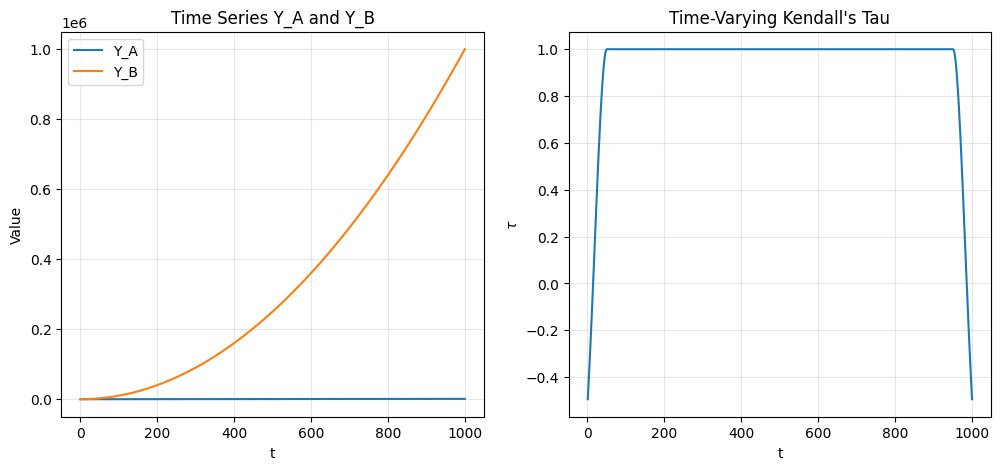

In [61]:
# test 1
Y_A = np.arange(1, 1001)
Y_B = np.power(Y_A, 2)
# Y_B = np.arange(100, 199)
S = 1000
t = np.arange(1, S+1)
tau_estimate = kendall_tau_estimator(Y_A, Y_B, h=0.05)
for time_point in [100, 500, 900]:
    print(f"Tau estimate at t={time_point} is {tau_estimate[time_point]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(t, Y_A, label='Y_A')
ax1.plot(t, Y_B, label='Y_B')
ax1.set_xlabel('t')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)
ax1.set_title('Time Series Y_A and Y_B')
ax1.legend()

ax2.plot(t, tau_estimate)
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\tau$')
ax2.set_title("Time-Varying Kendall's Tau")
ax2.grid(True, alpha=0.3)

#### Kendall estimation for two stocks

In [15]:
# load data
tickers_df = pd.read_parquet('artifacts/data_ingestion/tickers_df.parquet')
tickers_df.head()

Price,Adj Close,Close,High,Low,Open,Volume,Ticker,Year,Month,Weekday,Date
0,0.840094,0.999442,1.004464,0.907924,0.936384,535796800,AAPL,2000,1,0,2000-01-03
1,0.769266,0.915179,0.987723,0.903460,0.966518,512377600,AAPL,2000,1,1,2000-01-04
2,0.780523,0.928571,0.987165,0.919643,0.926339,778321600,AAPL,2000,1,2,2000-01-05
3,0.712977,0.848214,0.955357,0.848214,0.947545,767972800,AAPL,2000,1,3,2000-01-06
4,0.746751,0.888393,0.901786,0.852679,0.861607,460734400,AAPL,2000,1,4,2000-01-07


In [16]:
len(tickers_df)

300923

In [17]:
# calculate log returns


In [ ]:
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2024-12-31')

# Filter for a date range
price_data_range = tickers_df[
    (tickers_df['Date'] >= start_date) & 
    (tickers_df['Date'] <= end_date)
]
# ticker_given_date = tickers_df[tickers_df['Date']==choose_date]

# ticker_given_date = ticker_given_date[['Date','Adj Close', 'Ticker']].reset_index(drop=True)
# ticker_given_date.head()

In [9]:
price_data = price_data_range.pivot(index='Date', columns='Ticker', values='Adj Close')
price_data.head()

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AMD,AMZN,AVGO,BAC,BRK-B,...,QCOM,TMO,TSLA,TXN,UNH,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.261044,42.091415,36.418686,74.252617,72.339996,2.67,15.4260,7.574805,14.277452,149.169998,...,54.612598,124.014137,14.620667,39.911053,85.048477,61.462475,26.573202,40.370850,23.266567,58.423477
2015-01-05,23.577578,41.299297,36.426781,72.998924,71.980003,2.66,15.1095,7.453718,13.862695,147.000000,...,54.355259,122.310562,14.006000,39.291626,83.647614,60.105785,26.352501,39.263802,23.198858,56.824932
2015-01-06,23.579788,41.094879,36.013111,72.472351,70.529999,2.63,14.7645,7.284195,13.447927,146.839996,...,53.583282,121.168358,14.085333,38.642368,83.478836,59.718479,26.618467,38.444561,23.377617,56.522808
2015-01-07,23.910439,42.755787,36.305115,73.993523,71.110001,2.58,14.9210,7.480961,13.511738,148.880005,...,54.208229,124.798195,14.063333,39.336418,84.331184,60.518570,26.446692,38.673367,23.997887,57.095547
2015-01-08,24.829128,43.202961,37.051334,75.121857,72.919998,2.61,15.0230,7.854820,13.790905,151.369995,...,54.781696,126.095230,14.041333,39.978210,88.356575,61.330276,27.013533,39.529507,24.504374,58.045856


<Axes: xlabel='Ticker', ylabel='Ticker'>

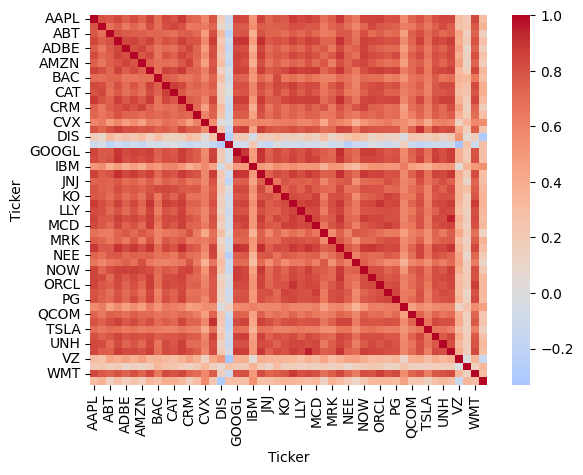

In [11]:
corr = price_data.corr(method='kendall')
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)

In [6]:
def plot_prices_tau(Y_A, Y_B, tau_estimate, t=None):
    S = len(Y_A)
    if t is None:
        t = np.arange(1, S+1)
    for time_point in [10, 50, 90]:
        print(f"Tau estimate at t={time_point} is {tau_estimate[time_point]}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(t, Y_A, label='Y_A')
    ax1.plot(t, Y_B, label='Y_B')
    ax1.set_xlabel('t')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Time Series Y_A and Y_B')
    ax1.legend()

    ax2.plot(t, tau_estimate)
    ax2.set_xlabel('t')
    ax2.set_ylabel(r'$\tau$')
    ax2.set_title("Time-Varying Kendall's Tau")
    ax2.grid(True, alpha=0.3)

In [78]:
Y_A = price_data['AAPL'].to_numpy()
Y_B = price_data['ABBV'].to_numpy()
date = price_data.index.to_list()

In [79]:
tau_estimate = kendall_tau_estimator(Y_A, Y_B, h=0.1)

Tau estimate at t=10 is -0.25032342189603185
Tau estimate at t=50 is 0.3837656694099194
Tau estimate at t=90 is 0.36665045825991305


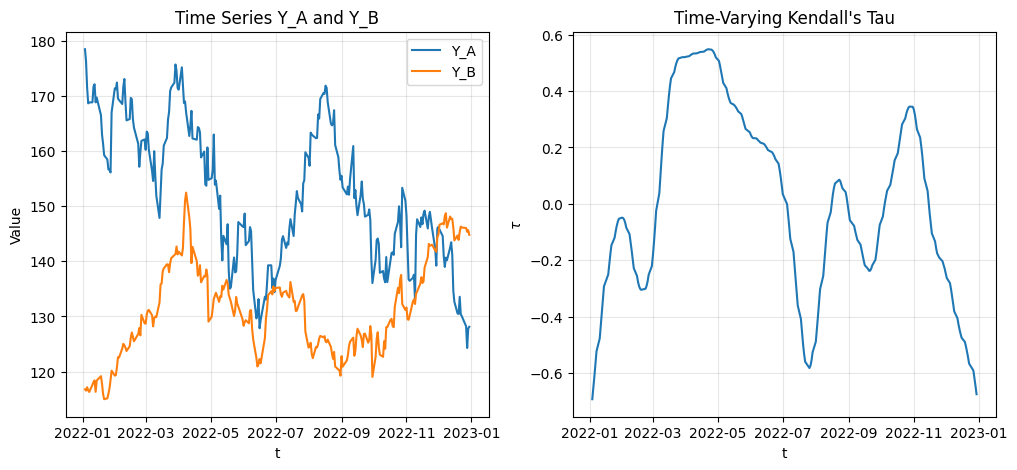

In [80]:
plot_prices_tau(Y_A, Y_B, tau_estimate, t=date)

Select the date range

In [30]:
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-12-31')

# Filter for a date range
price_data_range = tickers_df[
    (tickers_df['Date'] >= start_date) & 
    (tickers_df['Date'] <= end_date)
]
price_data = price_data_range.pivot(index='Date', columns='Ticker', values='Adj Close')
len(price_data)

251

Select the tickers

In [79]:
ticker_name = list(price_data.columns) 

In [80]:
## kendall tau matrix
# list(enumerate(ticker_name,11))
# ticker_name = ticker_name[0:5]
# print(ticker_name)

In [81]:
tau_stocks = []
for i in range(len(ticker_name)):
    tickerA = ticker_name[i]
    YA = price_data[tickerA].to_numpy()
    for j in range(i, len(ticker_name)):
        tickerB = ticker_name[j]
        YB = price_data[tickerB].to_numpy()
        tau_AB = kendall_tau_estimator(YA, YB, h=0.1)
        # print(i,j, tickerA, tickerB)
        tau_stocks.append(tau_AB)

In [83]:
type(tau_stocks[0])

list

In [86]:
%pwd

'c:\\Users\\Admin\\PhD Projects\\balance_continuous'

In [85]:
import pickle
with open('tau_stocks','wb') as f:
    pickle.dump(tau_stocks, f)

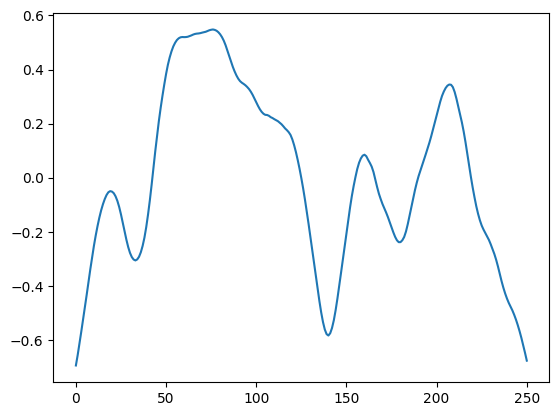

In [87]:
plt.plot(tau_stocks[1])

#### Convert to Correlation matrix

In [63]:
x= np.array(tau_stocks)
x.shape

(15, 251)

In [51]:
x  = [[1,2,1,0], [9,3,1,2], [1,2,3,0], [4,2,1,0],[3,2,5,1], [2,3,1,7]]
len(x[0])

4

In [88]:
def find_matrix_size(tickers):
    m = len(tickers)
    n = (-1 + np.sqrt(1+8*m))/2
    return int(n)

In [53]:
n = find_matrix_size(x)
T = len(x[0])
upp_tri_matrix = np.zeros((T,n,n))
sym_matrix = []
for t in range(T):
    idx=0
    for i in range(n):
        for j in range(i, n):
            upp_tri_matrix[t,i, j]= x[idx][t]
            idx+=1
    sym_matrix_t = np.triu(upp_tri_matrix[t], k=1) + upp_tri_matrix[t].T
    sym_matrix.append(sym_matrix_t)

In [89]:
find_matrix_size(tau_stocks)

50

Find the correlation matrix

In [90]:
def correlation_matrix(tau_stocks):
    n = find_matrix_size(tau_stocks)
    # n = len(tau_stocks)
    print(n)
    T = len(tau_stocks[0])
    upp_tri_matrix = np.zeros((T,n,n))
    corr_matrices = []
    for t in range(T):
        idx=0
        for i in range(n):
            for j in range(i, n):
                upp_tri_matrix[t,i, j]= tau_stocks[idx][t]
                idx+=1
        corr_matrix = np.triu(upp_tri_matrix[t], k=1) + upp_tri_matrix[t].T
        corr_matrices.append(corr_matrix)
    return corr_matrices

In [91]:
corr_matrices = correlation_matrix(tau_stocks)

50


In [94]:
corr_matrices[100]

array([[ 0.99536027,  0.27918263,  0.44185353, ...,  0.58010742,
         0.68676579, -0.08491441],
       [ 0.27918263,  0.99630528,  0.03078701, ...,  0.09523147,
         0.37574516, -0.35162219],
       [ 0.44185353,  0.03078701,  0.9992567 , ...,  0.69091573,
         0.26037382,  0.33444119],
       ...,
       [ 0.58010742,  0.09523147,  0.69091573, ...,  0.99724739,
         0.40477015,  0.2012715 ],
       [ 0.68676579,  0.37574516,  0.26037382, ...,  0.40477015,
         0.9958878 , -0.26700157],
       [-0.08491441, -0.35162219,  0.33444119, ...,  0.2012715 ,
        -0.26700157,  0.9992567 ]], shape=(50, 50))

### Signed Adjacency matrix

In [95]:
def LinkPol(Adj):
    """
    Parameters
    ----------
    Adj : signed adjacency matrix.

    Returns
    -------
    pol : Mean link polarization.
    """
    pol = 0.5*(sum(sum(Adj)))
    return pol

In [99]:
num_edges = comb(50,2)

In [101]:
LinkPol(corr_matrices[150])/num_edges

np.float64(0.4046890670099751)

In [ ]:
# create adjacency matrix from kendall tau
def indicator(func):
    def _f(x, epsilon):
        return func(x)  if np.abs(x) >= epsilon else 0
    return _f

In [29]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        return func(*args, **kwargs)
    return wrapper_do_twice

In [21]:
@do_twice
def say_whee():
    print("whee")

In [22]:
say_whee()

whee
whee


In [24]:
@do_twice
def greet(name):
    print(f"Hello {name}")

greet('World')

Hello World
Hello World


In [30]:
@do_twice
def return_greeting(name):
    print("Creating greeting")
    return f"Hi {name}"

hi_adam =return_greeting("Adam")
print(hi_adam)

Creating greeting
Creating greeting
Hi Adam
